In [250]:
import copy
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from utils.plot_utils import set_fontsize
from utils.binning_utils import bin_dataset_switching
from utils.hdf_utils import load_measurement_data_devices_attrs
from utils.plot_utils import plot_binned_dataset_switching
from utils.binning_utils import bin_data, find_nearest_idx, combine_arrays_irregular, \
                                average_binned_data, bin_dataset_switching

In [50]:
fname = "2020_10_30.hdf"
dset_name = "1604086729 scan RC power"
dset_name1 = "1604088942 scan RC power from last stop"
dset_name2 = "1604090906 RC max power"

devices = ()

### Fast Estimate: Averaging Traces to get ratio

In [69]:
pmt_channel = 1
shutter_channel = 2

traces_currents = {cur: {'open': [], 'closed': []} for cur in [5, 5.25, 5.5, 5.75, 6, 6.25, 6.5]}

for dname in tqdm([dset_name, dset_name1, dset_name2]):
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dname, devices)
    attr_name = 'Seed1Amplifier SetCurrentGUI'
#     print(pxie_attrs[1][attr_name])
    
    if dname == "1604086729 scan RC power":
        seed1amp_currents = {idx: attrs[attr_name] for idx, attrs in pxie_attrs.items() if attrs[attr_name] < 5.75}
    elif dname == "1604088942 scan RC power from last stop":
        seed1amp_currents = {idx: attrs[attr_name] for idx, attrs in pxie_attrs.items() if attrs[attr_name] < 6.5}
    else:
        seed1amp_currents = {idx: float(attrs[attr_name]) for idx, attrs in pxie_attrs.items()}
        
    for idx, cur in seed1amp_currents.items():
        traces = pxie[idx]
        pmt = -traces[:,pmt_channel].astype(float)
        pmt -= np.mean(np.append(pmt[:250], pmt[-100:]))
        shutter_state = traces[:,shutter_channel].mean() > 2e4
        if shutter_state:
            traces_currents[cur]['open'].append(pmt)
        else:
            traces_currents[cur]['closed'].append(pmt)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:44<00:00, 14.71s/it]


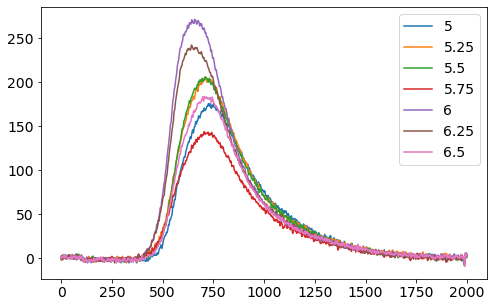

In [77]:
fig, ax = plt.subplots(figsize = (8,5))
for c in [5, 5.25, 5.5, 5.75, 6, 6.25, 6.5]:
    ax.plot(np.mean(traces_currents[c]['open'], axis = 0), label = c)
#     ax.plot(np.mean(traces_currents[c]['closed'], axis = 0), label = c)
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

In [72]:
for c in [5, 5.25, 5.5, 5.75, 6, 6.25, 6.5]:
    io = np.trapz(np.mean(traces_currents[c]['open'], axis = 0))
    ic = np.trapz(np.mean(traces_currents[c]['closed'], axis = 0))
    print(f'{c:.2f} A -> {io/ic:.3f} ratio')

5.00 A -> 2.610 ratio
5.25 A -> 2.628 ratio
5.50 A -> 2.599 ratio
5.75 A -> 2.525 ratio
6.00 A -> 2.634 ratio
6.25 A -> 2.551 ratio
6.50 A -> 2.574 ratio


### Filtering out values where the integral with the shutter open is too small
Also removing then the values with the shutter open next to them

In [251]:
pmt_channel = 1
shutter_channel = 2

pmt_data = {c: [] for c in [5, 5.25, 5.5, 5.75, 6, 6.25, 6.5]}
shutter_data = {c: [] for c in [5, 5.25, 5.5, 5.75, 6, 6.25, 6.5]}

for dname in tqdm([dset_name, dset_name1, dset_name2]):
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(fname, dname, devices)
    indices = sorted(list(pxie.keys()))
    
    attr_name = 'Seed1Amplifier SetCurrentGUI'
    for idx in indices:
        c = float(pxie_attrs[idx][attr_name])
        pmt_data[c].append(pxie[idx][:,pmt_channel])
        shutter_data[c].append(pxie[idx][:,shutter_channel].mean() > 2e4)

for key, val in pmt_data.items():
    pmt_data[key] = np.array(val).astype(float)
    
for key, val in shutter_data.items():
    shutter_data[key] = np.array(val)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:45<00:00, 15.05s/it]


In [258]:
normalized_pmt_data = copy.deepcopy(pmt_data)

for key, val in normalized_pmt_data.items():
    normalized_pmt_data[key] -= np.mean(val[:,:250], axis = 1)[:,np.newaxis]
    normalized_pmt_data[key] *= -1

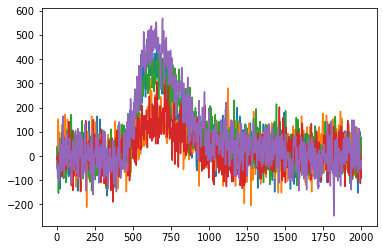

In [259]:
plt.plot(normalized_pmt_data[5][:5].T)

In [260]:
integrals = {}
for key, val in normalized_pmt_data.items():
    integrals[key] = np.trapz(val, axis = 1)

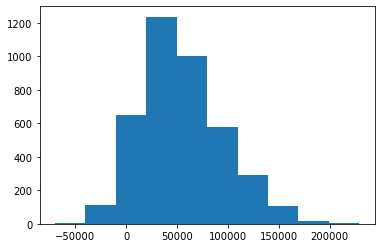

In [261]:
plt.hist(integrals[5]);

In [462]:
integral_min = 2e4
integral_max = 1e6
filter_masks = {}
filtered_data = {}

for key, val in integrals.items():
    d = val.copy()
    m = np.ones(val.shape).astype(bool)
    shutter_start = shutter_data[key][0]
    # select only values with the shutter open
    if shutter_start:
        mask_open = np.s_[::2]
        mask_closed = np.s_[1::2]
        
    else:
        mask_open = np.s_[1::2]
        mask_closed = np.s_[::2]
    filtered = np.where((d[mask_open] < integral_min) | (d[mask_open] > 1e6))[0]
    d[mask_open][filtered] = np.nan
    m[mask_open][filtered] = False
    d[mask_closed][filtered] = np.nan
    m[mask_closed][filtered] = False
        
    filtered_data[key] = d
    filter_masks[key] = m

In [463]:
def ratio_error(a,b,σa,σb):
    return np.sqrt((a/b)**2 * ((σa/a)**2 + (σb/b)**2))

In [464]:
ratios = {}
for key, val in filtered_data.items():
    shutter_start = shutter_data[key][0]
    # select only values with the shutter open
    if shutter_start:
        mask_open = np.s_[::2]
        mask_closed = np.s_[1::2]
        
    else:
        mask_open = np.s_[1::2]
        mask_closed = np.s_[::2]
    inta = np.nanmean(val[mask_open])
    stda = np.nanstd(val[mask_open])/np.sqrt((~np.isnan(val[mask_open])).sum())
    intb = np.nanmean(val[mask_closed])
    stdb = np.nanstd(val[mask_closed])/np.sqrt((~np.isnan(val[mask_open])).sum())
    err = ratio_error(inta,intb, stda, stdb)
    ratios[key] = (inta/intb, err)
    print(f'{key:.2f} A -> {inta/intb:.3f} +/- {err:.3f}  ratio')

5.00 A -> 2.716 +/- 0.059  ratio
5.25 A -> 2.668 +/- 0.050  ratio
5.50 A -> 2.669 +/- 0.049  ratio
5.75 A -> 2.862 +/- 0.057  ratio
6.00 A -> 2.687 +/- 0.039  ratio
6.25 A -> 2.597 +/- 0.045  ratio
6.50 A -> 2.751 +/- 0.047  ratio


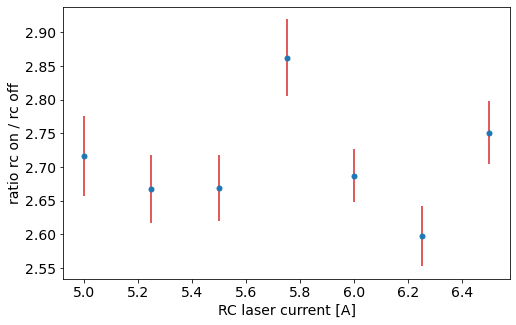

In [465]:
currents = list(ratios.keys())
ratio, err = zip(*ratios.values())

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(currents, ratio, yerr = err, fmt = '.', ms = 10, ecolor = 'C3')

ax.set_xlabel('RC laser current [A]')
ax.set_ylabel('ratio rc on / rc off')

set_fontsize(ax, 14)

5.00 A -> 2.716 +/- 0.006  ratio
5.25 A -> 2.668 +/- 0.005  ratio
5.50 A -> 2.669 +/- 0.005  ratio
5.75 A -> 2.862 +/- 0.005  ratio
6.00 A -> 2.687 +/- 0.004  ratio
6.25 A -> 2.597 +/- 0.005  ratio
6.50 A -> 2.751 +/- 0.005  ratio


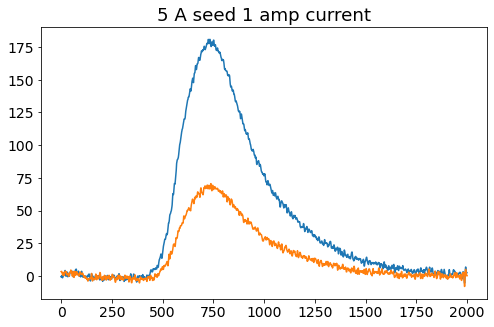

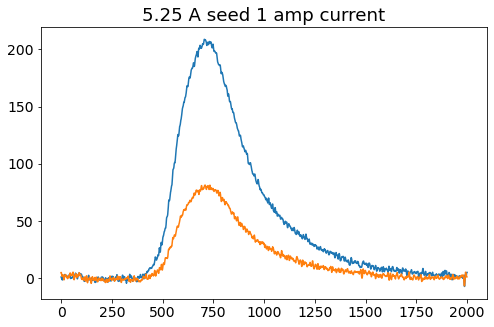

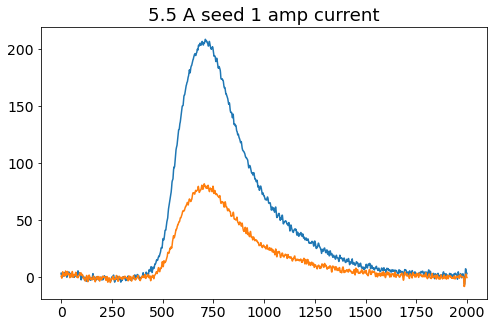

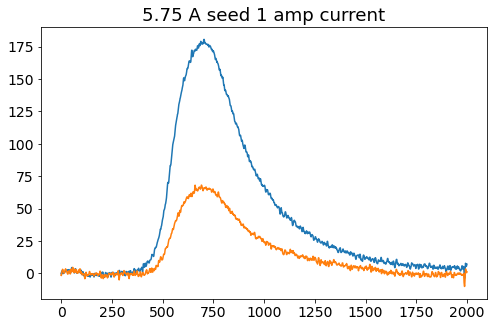

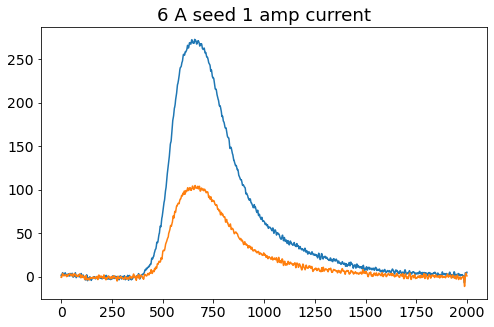

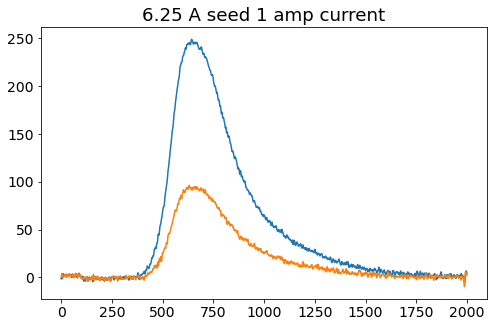

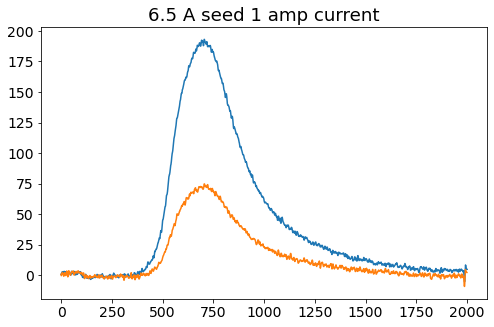

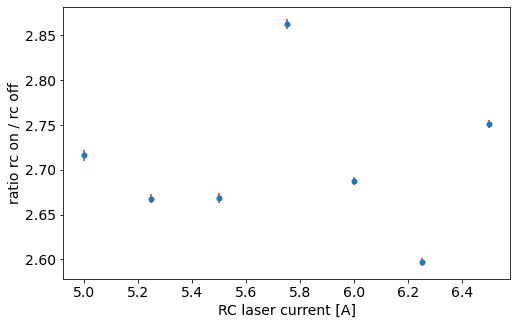

In [468]:
for key, m in filter_masks.items():
    dat = normalized_pmt_data[key][m].copy()
    shutter_start = shutter_data[key][m][0]
    # select only values with the shutter open
    
    if shutter_start:
        mask_open = np.s_[::2]
        mask_closed = np.s_[1::2]
        
    else:
        mask_open = np.s_[1::2]
        mask_closed = np.s_[::2]
        
    d_open = dat[mask_open]
    d_closed = dat[mask_closed]
    
    inta = np.trapz(np.mean(d_open, axis = 0))
    intb = np.trapz(np.mean(d_closed, axis = 0))
    stda = np.sqrt(np.sum(((np.std(d_open, axis = 0))/np.sqrt(len(d_open)))**2))
    stdb = np.sqrt(np.sum(((np.std(d_closed, axis = 0))/np.sqrt(len(d_closed)))**2))
    
    fig, ax = plt.subplots(figsize = (8,5))
    ax.plot(np.mean(d_open, axis = 0))
    ax.plot(np.mean(d_closed, axis = 0))
    ax.set_title(f'{key} A seed 1 amp current', fontsize = 14)
    set_fontsize(ax, 14)
    
    err = ratio_error(inta,intb, stda, stdb)
    ratios[key] = (inta/intb, err)
    print(f'{key:.2f} A -> {inta/intb:.3f} +/- {err:.3f}  ratio')

currents = list(ratios.keys())
ratio, err = zip(*ratios.values())

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(currents, ratio, yerr = err, fmt = '.', ms = 10, ecolor = 'C3')

ax.set_xlabel('RC laser current [A]')
ax.set_ylabel('ratio rc on / rc off')

set_fontsize(ax, 14)